# Evaluation of ion suppression correction

In this notebook, I explore different measures to quantify the effect of correcting SpaceM ion intensity data for partial pixel-cell overlap.
 

In [1]:
import os
import platform
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from src.correction import *
from src import const
from sklearn.cluster import KMeans
from importlib import reload
# import outer_spacem as osm

In [2]:
if platform.system() == "Darwin":
    target_path = '/Volumes/mklein/FDA_project/data/Mx_Co_Cultured'
else:
    target_path = '/home/mklein/FDA_project/data/Mx_Co_Cultured'

condition_name = 'celltype'

The conditions data for the co-culture datasets is established using fluorescence microscopy. The following code is adapted from Martijn and just shows the classification of fluorescence values to celltypes

In [3]:
adata = sc.read(os.path.join(target_path, 'pipeline_files/batch_sm_matrix.h5ad'))
adata_cor = sc.read(os.path.join(target_path, 'pipeline_files/corrected_batch_sm_matrix.h5ad'))

HeLa      715
NIH3T3    492
Name: celltype, dtype: int64


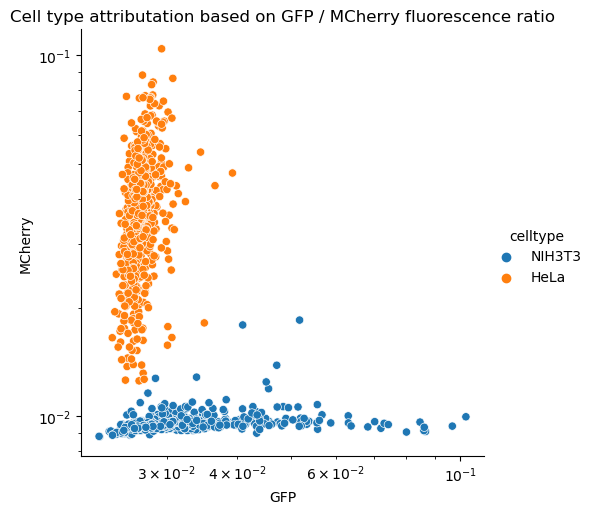

In [4]:
condition_metadata = pd.read_csv(os.path.join(target_path,'MORPHnMOL.csv'))
condition_metadata.index = [const.CELL_PRE + str(i) for i in condition_metadata.ObjectNumber]
condition_metadata['GFP'] = condition_metadata.Intensity_MeanIntensity_GFP_quantif
condition_metadata['MCherry'] = condition_metadata.Intensity_MeanIntensity_mCherry_quantif
condition_metadata['fluorescence_ratio'] = np.log(condition_metadata.GFP / condition_metadata.MCherry)

#condition_metadata['celltype'] = 'HeLa' if condition_metadata.fluorescence_ratio < 0.8 else 'NIH3T3'
condition_metadata['celltype'] = np.where(condition_metadata.fluorescence_ratio < 0.8, 'HeLa', 'NIH3T3')

print(condition_metadata['celltype'].value_counts())

plot = sns.relplot(data=condition_metadata, x='GFP', y='MCherry', hue='celltype')
plot.set(xscale='log')
plot.set(yscale='log')
plot.set(title='Cell type attributation based on GFP / MCherry fluorescence ratio')

The co-culture dataset was originally used in the original SpaceM manuscript. The corresponding metadata file `MORPHnMOL.csv` subsets the list of annotated molecules from 104 to 58. Consequently, only these molecules will be explored in the following. Analogously, only the cells present in both the uncorrected and corrected spatiomolecular matrices are kept for the analysis.

In [5]:
included_cells = adata.obs.index.intersection(condition_metadata.index)
all_molecules = adata.var.index
included_molecules = adata.var.index.intersection(condition_metadata.columns)

adata = adata[included_cells, all_molecules]
adata_cor = adata_cor[included_cells, all_molecules]

print(adata.shape)
print(adata_cor.shape)

(1207, 58)
(1207, 58)


In the following, both spatiomolecular matrices are filtered and scaled to zero-mean and unit variance.

In [6]:
def preprocess(adata):
    sc.pp.filter_cells(adata, min_genes=5)
    sc.pp.filter_genes(adata, min_cells=1)
    adata.raw = adata
    # sc.pp.normalize_total(adata, target_sum=None)
    # sc.pp.log1p(adata)
    sc.pp.scale(adata)

preprocess(adata)
preprocess(adata_cor)


print(adata.shape)
print(adata_cor.shape)


(1137, 58)
(1137, 58)


/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [7]:
adata.obs['correction'] = 'uncorrected'
adata_cor.obs['correction'] = 'ISM correction'

In [25]:
for ion in adata.var_names:
    if len(((adata.to_df()['C37H71O8P'] == 0) & (adata_cor.to_df()['C37H71O8P']!= 0)).value_counts()) > 1:
        print(ion)

In [8]:
conc_adata = ad.concat({'uncorrected': adata, 'ISM correction': adata_cor}, label='correction', index_unique='_', merge='same')

In [9]:
sc.tl.rank_genes_groups(adata=conc_adata, groupby='correction', use_raw=True, method='t-test_overestim_var')

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.

In [10]:
all_ions_dea = sc.get.rank_genes_groups_df(conc_adata, group='ISM correction')
# tops_dea = pd.concat({'strongly_corr': top_uncor, 'hardly_corr': top_cor})

adata_cor.var['names'] = adata_cor.var.index
impact_ions = pd.merge(all_ions_dea, adata_cor.var[['names', 'correction_using_ion_pool', 'correction_n_iterations', 'correction_n_datapoints', 'correction_quantreg_slope']], on='names', how='left')
impact_ions = impact_ions.sort_values(by='scores')

sign_impact_ions = impact_ions.loc[(impact_ions['pvals'] < 0.001) & 
                                   (impact_ions['scores'] < -2)]
impact_ions

,names,scores,logfoldchanges,pvals,pvals_adj,correction_using_ion_pool,correction_n_iterations,correction_n_datapoints,correction_quantreg_slope
57,C18H36O2,-17.634972,NaN,2.161421e-64,1.253624e-62,False,50,1199,-0.870044
56,C19H37O6P,-15.897961,NaN,2.744945e-53,7.960342e-52,False,55,1199,-0.862567
55,C21H41O6P,-15.456485,NaN,8.523231e-51,1.647825e-49,False,50,1199,-0.842036
54,C35H69O8P,-15.013201,-223.107941,6.014576e-48,8.721135e-47,False,53,1190,-1.077399
53,C21H43O7P,-14.978187,-176.138031,7.998049e-48,9.277737e-47,False,56,1184,-1.002771
52,C19H39O7P,-13.888738,-149.335220,8.787171e-42,8.494265e-41,False,60,1182,-0.895607
51,C27H53O12P,-12.108463,NaN,1.292244e-32,1.070717e-31,False,35,1197,-0.759358
50,C23H48NO7P,-11.809659,-153.818237,3.626930e-31,2.629524e-30,False,49,1186,-0.707036
49,C6H13O9P,-10.133627,NaN,1.307206e-23,8.424215e-23,False,55,1198,-0.677839
48,C34H68NO6P,-9.568450,-203.360550,3.305670e-21,1.917289e-20,False,39,1123,-1.031471


In [11]:
# from bioinfokit import visuz
# visuz.GeneExpression.volcano(df=impact_ions.replace(np.Inf, np.nan).dropna(), lfc='logfoldchanges', pv='pvals_adj', show=True)
# impact_ions.replace(np.Inf, np.nan).dropna().sort_values('logfoldchanges')

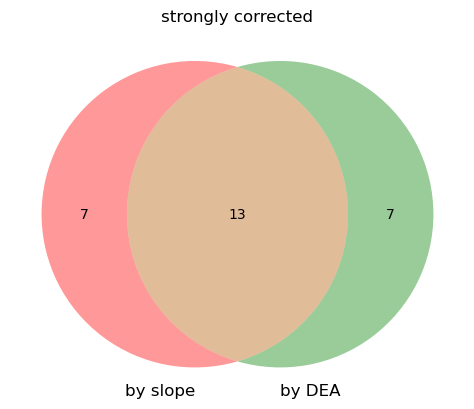

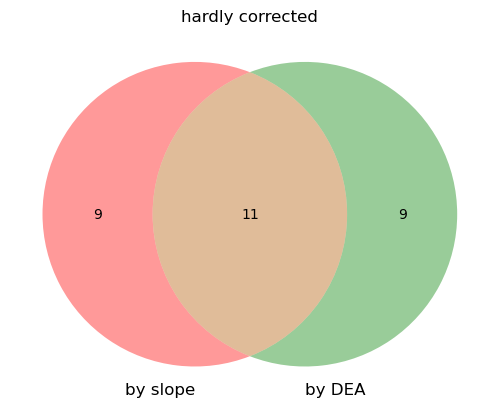

In [12]:
from matplotlib_venn import venn2

top = 20
impact_ions_fc = impact_ions.sort_values(by='logfoldchanges')

venn2([set(impact_ions.head(top).index),
       set(impact_ions_fc.head(top).index)],
       set_labels = ['by slope', 'by DEA']
)
plt.title('strongly corrected')
plt.show()
venn2([set(impact_ions.tail(top).index),
       set(impact_ions_fc.tail(top).index)],
       set_labels = ['by slope', 'by DEA']
)
plt.title('hardly corrected')
plt.show()

In [11]:
conc_adata_raw = conc_adata.copy()
conc_adata_raw.X = conc_adata_raw.raw.X
changed_ions_df = sc.get.obs_df(conc_adata_raw, keys=(['correction', 'celltype', 'ObjectNumber']+list(conc_adata.var_names)))
plot_df = changed_ions_df.melt(id_vars=['correction', 'celltype', 'ObjectNumber'], var_name='ion').pivot(index=['ion', 'celltype', 'ObjectNumber'], columns='correction', values='value')
plot_df.reset_index(level=[0, 1], inplace=True)

/tmp/ipykernel_171/1031242053.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  impact_ions['pearson'] = [plot_df[plot_df.ion == ion].corr()['uncorrected']['ISM correction'] for ion in impact_ions['names']]


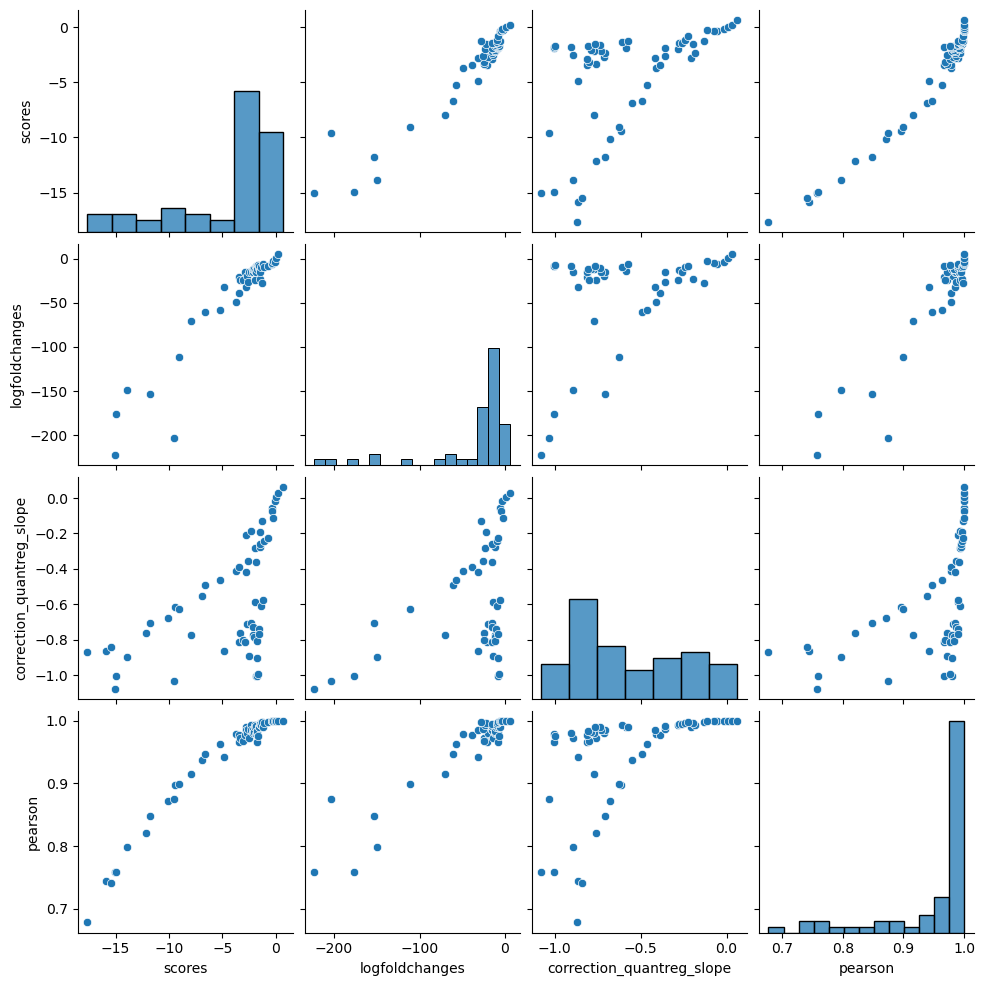

In [12]:
impact_ions['pearson'] = [plot_df[plot_df.ion == ion].corr()['uncorrected']['ISM correction'] for ion in impact_ions['names']]
sns.pairplot(impact_ions[['scores', 'logfoldchanges', 'correction_quantreg_slope', 'pearson']])

In [14]:
# plot_df['ISM correction_intersect'] = plot_df['ISM correction'] * [ 10 ** adata_cor.var.loc[ion, 'correction_quantreg_intersect'] for ion in plot_df['ion']]

/tmp/ipykernel_171/1204562358.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson = [plot_df[plot_df.ion == ion].corr()['uncorrected']['ISM correction'] for ion in ions]


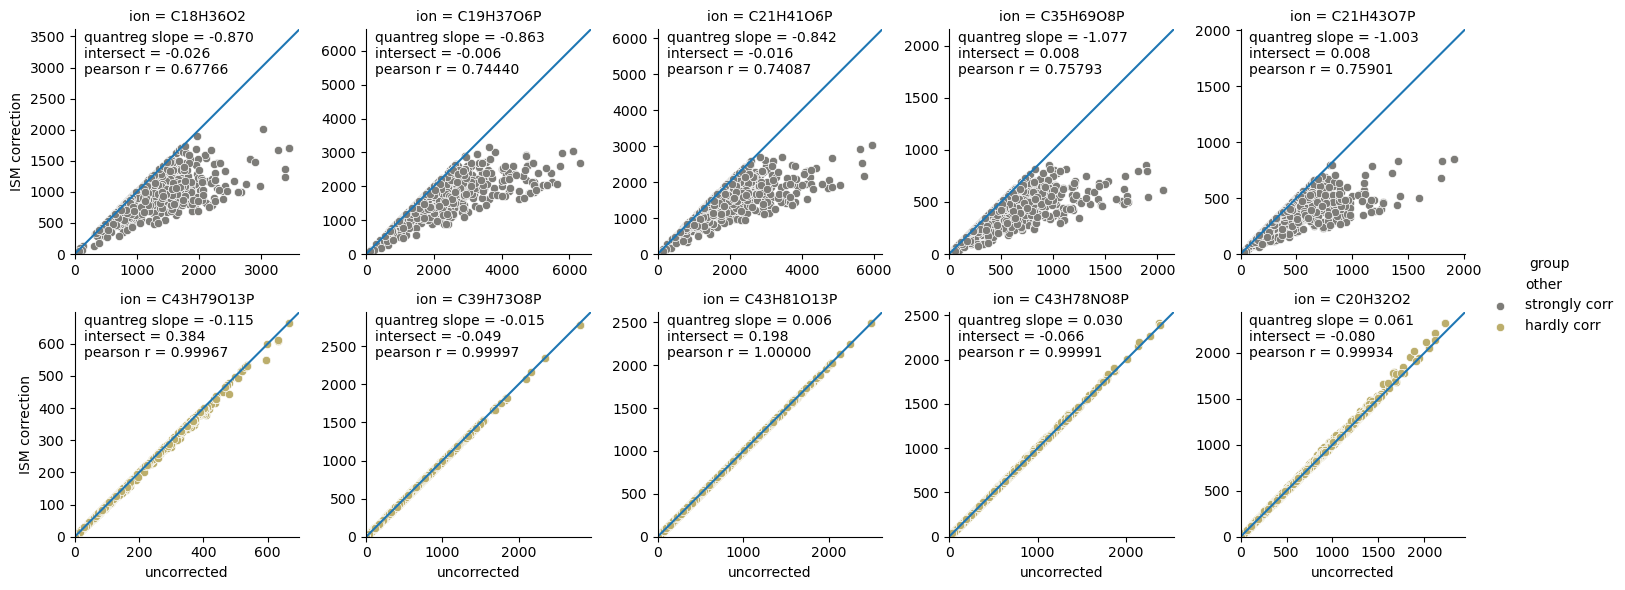

In [15]:
ions_corr = list(impact_ions['names'].head())
ions_uncorr = list(impact_ions['names'].tail())
ions = ions_corr + ions_uncorr #+ ['C27H53O12P', 'C18H36O2', 'C41H80NO8P', 'C39H73O8P', 'C43H81O13P', 'C35H69O8P']
# ions = list(set(ions))
plot_df['group'] = ['strongly corr' if (ion in ions_corr) else 'hardly corr' if (ion in ions_uncorr) else 'other' for ion in plot_df['ion'] ]

slopes = [adata_cor.var.loc[ion, 'correction_quantreg_slope'] for ion in ions]
intersects = [adata_cor.var.loc[ion, 'correction_quantreg_intersect'] for ion in ions]
pearson = [plot_df[plot_df.ion == ion].corr()['uncorrected']['ISM correction'] for ion in ions]
grid = sns.FacetGrid(plot_df, col='ion', hue='group', col_wrap=5, sharex=False, sharey=False, col_order=ions, palette='cividis')
grid.map(sns.scatterplot, 'uncorrected', 'ISM correction').add_legend()
grid.set(aspect = 1)
for i, ax in enumerate(grid.axes.flat): 
    lim = max([ax.get_xlim()[1], ax.get_ylim()[1]])
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.axline((0,0), slope=1)
    ax.text(0.04*lim, 0.8*lim, 'quantreg slope = %1.3f\nintersect = %1.3f\npearson r = %1.5f'%(slopes[i], intersects[i], pearson[i]))
   

In [40]:
ea_ad = conc_adata_raw.copy().transpose()

df = ea_ad.to_df()
df.to_csv(os.path.join(target_path, 'Mx_coculture_lion_table.csv'))
#sign_impact_ions['names']
metadata = pd.concat({'sample':pd.Series(df.columns), 'condition': pd.Series(cond)}, axis = 1)
metadata = metadata.set_index('sample')
metadata.to_csv(os.path.join(target_path, 'Mx_coculture_metadata.csv'))

In [ ]:
cond = list(ea_ad.var['correction'])
annot = list(ea_ad.obs_names)

data = [df, annot, cond]

In [24]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

bmet = importr('bmetenrichr', lib_loc='/home/mklein/.conda/envs/ion_suppression/lib/R/library')
pbl = importr('pbapply', lib_loc='/home/mklein/.conda/envs/ion_suppression/lib/R/library')
base = importr('base')

In [19]:
with localconverter(ro.default_converter + pandas2ri.converter):
    scmatrix = ro.conversion.py2rpy(df)
    annotations = ro.conversion.py2rpy(annot)
    conditions = ro.conversion.py2rpy(cond)

/home/mklein/.conda/envs/ion_suppression/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [25]:
enr = bmet.initEnrichment(scmatrix = base.as_matrix(scmatrix),
                 annotations = base.as_character(annotations),
                 conditions = base.as_character(conditions),
                 condition_x = "uncorrected",
                 condition_y = "ISM correction"
                )

enr = bmet.rankScore(enr, 't.test')
enr = bmet.calcEnrichment(enr, 100)



Parsing isomers...
single-cell metabolomics matrix of 58 metabolites and 2274 cells
active pathway: LION 

conditions: uncorrected, ISM correction 

condition.x: uncorrected 
condition.y: ISM correction 

Bootstrapping...
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01s           |+                                                 | 2 % ~01s           |++                                                | 3 % ~01s           |++                                                | 4 % ~01s           |+++                                               | 5 % ~01s           |+++                                               | 6 % ~01s           |++++                                              | 7 % ~01s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |+++++                                             | 10

R[write to console]: 93.1% of annotations were matched to pathway




Perform enrichment analysis...
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~05s           |+                                                 | 2 % ~05s           |++                                                | 3 % ~04s           |++                                                | 4 % ~04s           |+++                                               | 5 % ~04s           |+++                                               | 6 % ~05s           |++++                                              | 7 % ~05s           |++++                                              | 8 % ~05s           |+++++                                             | 9 % ~05s           |+++++                                             | 10% ~04s           |++++++                                            | 11% ~05s           |++++++                                            | 12% ~05s           |+++++++                      

In [26]:
# bmet.plotEnrichment(enr, min_annotations = 1, q_value_cutoff = .2, by_statistic = "ES")
bmet.plotEnrichment(enr, 1, 0.5, "ES")

R[write to console]: Error in plotEnrichment.bmetenrich(list(scmatrix = c(265.808380126953,  : 
  Not enough enriched terms to visualize



RRuntimeError: Error in plotEnrichment.bmetenrich(list(scmatrix = c(265.808380126953,  : 
  Not enough enriched terms to visualize


In [27]:
enr

<rpy2.robjects.vectors.ListVector object at 0x7f2cab4b8cc0> [RTYPES.VECSXP]
R classes: ('bmetenrich',)
[FloatSexp..., ListSexpV..., NULLType, NULLType, ..., StrSexpVe..., StrSexpVe..., ListSexpV..., ListSexpV...]
  scmatrix: <class 'rpy2.robjects.vectors.FloatMatrix'>
  <rpy2.robjects.vectors.FloatMatrix object at 0x7f2cd6963380> [RTYPES.REALSXP]
R classes: ('matrix', 'array')
[265.808380, 489.958191, 870.396118, 1267.842773, ..., 403.948853, 7431.572266, 3101.317139, 669.905701]
<rpy2.robjects.vectors.ListVector object at 0x7f2cab4b8cc0> [RTYPES.VECSXP]
R classes: ('bmetenrich',)
[FloatSexp..., ListSexpV..., NULLType, NULLType, ..., StrSexpVe..., StrSexpVe..., ListSexpV..., ListSexpV...]
  annotation.weights: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f2cd653afc0> [RTYPES.NILSXP]
  isobars_list: <class 'rpy2.rinterface_lib.sexp.NULLType'>
  <rpy2.rinterface_lib.sexp.NULLType object at 0x7f2cd653afc0> [RTYPES.NILSXP]
...
  include: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f2cab525ec0> [RTYPES.STRSXP]
R classes: ('character',)
['ISM correction']
  pathway: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7f2c86f41b80> [RTYPES.STRSXP]
R classes: ('character',)
['t.test']
<rpy2.robjects.vectors.ListVector object at 0x7f2cab4b8cc0> [RTYPES.VECSXP]
R classes: ('bmetenrich',)
[FloatSexp..., ListSexpV..., NULLType, NULLType, ..., StrSexpVe..., StrSexpVe..., ListSexpV..., ListSexpV...]
<rpy2.robjects.vectors.ListVector object at 0x7f2cab4b8cc0> [RTYPES.VECSXP]
R classes: ('bmetenrich',)
[FloatSexp..., ListSexpV..., NULLType, NULLType, ..., StrSexpVe..., StrSexpVe..., ListSexpV..., ListSexpV...]

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R


In [ ]:
# library(bmetenrichr)

matrix <- data[[1]]
print(matrix[1:10,1:10])

test <-
  initEnrichment(scmatrix = data[[1]],
                 annotations = as.character(data[[2]]),
                 conditions = as.character(data[[3]]),
                 condition.x = "uncorrected",
                 condition.y = "ISM correction"
                )
    
# test <- rankScore(test, ranking.by = 't.test')
# test <- calcEnrichment(test, n = 100)
# plotEnrichment(test, min.annotations = 1, q.value.cutoff = .2, by.statistic = "ES")

In the following graphs, the uncorrected data is shown before the corrected data. Initially, the data is visualized using PCA and UMAP

In [ ]:
def dimred_pca(adata):
    sc.pp.pca(adata)
    sc.pl.pca_overview(adata, color='celltype')

dimred_pca(adata)
dimred_pca(adata_cor)

In [ ]:
def dimred_umap(adata, min_dist = 0.5):
    sc.pp.neighbors(adata, n_neighbors=200, metric='cosine')
    sc.tl.umap(adata, min_dist=min_dist, spread=2.0, random_state=1, n_components=2)
    sc.pl.umap(adata, color=condition_name)
    # f = osm.pl.highlight_scatterplot(
    #     data = adata,
    #     obsm_key = "X_umap",
    #     hue = condition_name,
    #     col = condition_name,
    #     palette = "cividis",
    #     height = 5,
    #     scatter_kwargs = dict(s=10)
    # )

    # f.add_legend(markerscale=3)

    # plt.xticks([])
    # plt.yticks([])
    # plt.show()

dimred_umap(adata)
dimred_umap(adata_cor)


There exist several methods for unsupervised clustering, that can be applied to dimensionality-reduced data. Here, I show kMeans clustering, Leiden clustering and a variant of the latter (adapted from the SpaceM manuscript: curated leiden). Both kMeans and Leiden clustering appear to fail at distinguishing the two celltypes as they split the data along the short axis of the UMAP visualization. However, the celltypes are separated along the long axis. The curated Leiden algorithm from Rappez et al. finds smaller Leiden clusters and assigns them to either celltype depending on the nature of the majority of cells. This method of finer granularity does better reproduce the separation between the two celltypes.

In [ ]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import accuracy_score, silhouette_score

def clustering_methods(adata):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(adata.X)
    adata.obs['kmeans'] = kmeans.labels_.astype(str)

    sc.tl.leiden(adata, resolution=0.3)
    sc.tl.leiden(adata, resolution=2, key_added='leiden_fine')

    leiden = np.array(adata.obs['leiden_fine'].values)
    leiden_curated = np.copy(leiden)
    fc = np.array(adata.obs['celltype'].values)
    for cluster in np.unique(leiden):
        labels, counts = np.unique(fc[leiden == cluster], return_counts=True)
        leiden_curated[leiden == cluster] = str(labels[counts == np.max(counts)][0])
    adata.obs['leiden_curated'] = leiden_curated

    sc.pl.umap(adata, color=['kmeans', 'leiden', 'leiden_curated', 'celltype'])
    print('Leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'].replace(['HeLa', 'NIH3T3'], ['0', '1']), y_pred = adata.obs['leiden']))
    print('Curated leiden acccuracy score: %1.4f' % accuracy_score(y_true = adata.obs['celltype'], y_pred = adata.obs['leiden_curated']))
    print('KMeans completeness score: %1.4f' % completeness_score(adata.obs['celltype'], adata.obs['kmeans']))
    print('KMeans silhouette coefficient: %1.4f' % silhouette_score(adata.X, adata.obs['kmeans']))

clustering_methods(adata)
clustering_methods(adata_cor)


Linear discriminant analysis is a linear classifier that can be trained and applied to the ion intensity data in order to further examine the separation of the different conditions (celltypes). In general, the performance of the classifier depends on the underlying data, the trained model and how they work with each other. Assuming the model itself has equal performance in both cases, higher the accuracy of the classifier can be attributed to a better separation of the data.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

def test_classifier(adata, model, predictors, result, name):
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
    scores = cross_val_score(model, predictors, result, scoring='accuracy', cv=cv, n_jobs=multiprocessing.cpu_count())
    
    adata.obs[name] = model.predict(adata.X)
    sc.pl.umap(adata, color=['celltype', 'lda'])
    print("Classification accuracy after 10-fold cross-validation: %1.4f (±%1.4f)" % (np.mean(scores), np.std(scores)))  

def LDA(adata):
    predictors = adata.X
    result = adata.obs['celltype']
    model = LinearDiscriminantAnalysis()
    model.fit(predictors, result)  

    test_classifier(adata, model, predictors, result, name = 'lda')

LDA(adata) 
LDA(adata_cor) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(adata, max_depth = 10):
    predictors = adata.X
    result = adata.obs['celltype']
    model = RandomForestClassifier(random_state=1, max_depth=max_depth)
    model.fit(predictors, result)  

    test_classifier(adata, model, predictors, result, name = 'random_forest') 


random_forest(adata) 
random_forest(adata_cor) 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline

def knn_classifier(adata, n_neighbors = 20):
    predictors = adata.X
    result = adata.obs['celltype']
    nca = NeighborhoodComponentsAnalysis(random_state=1)
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    model = Pipeline([('nca', nca), ('knn', knn)])
    knn.fit(predictors, result)  

    test_classifier(adata, knn, predictors, result, name = 'knn')


knn_classifier(adata) 
knn_classifier(adata_cor) 

Finally, Martijn developed an intermixing metric for the separation of different conditions based on the local neighborhood (euclidian distance) of every data point in dimensionality-reduced space. I have extended this single-valued measure to a curve on neighborhood-scale and introduced a correction factor for unbalanced datasets. For the co-culture dataset, this metric shows a clear difference in the group intermixing of uncorrected and corrected ion intensities. Intermixing is almost 50% lower after correction across neighborhood sizes.

In [ ]:
from src.evaluation import intermixing, intermixing_metric_sampled
intermixing({'uncorrected': adata, 'ISM correction': adata_cor}, condition_name=condition_name, sample_frac=0.2)

For a better comparison to Martijns results, I also calculate the intermixing metric for the fixed neighborhood of $n=10$, with and without normalization to group imbalance. Martijn reports intermixing values of $0.152$ for ISM correction and $0.215$ for uncorrected data.

In [ ]:
pd.concat([intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=True),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=True),
intermixing_metric_sampled(adata, condition_name, neighborhood_size=[10], n_datapoints=1, label='none', normalized=False),
intermixing_metric_sampled(adata_cor, condition_name, neighborhood_size=[10], n_datapoints=1, label='ISM', normalized=False)], axis=0, keys=['none', 'ISM', 'none_raw', 'ISM_raw'])

As visible in UMAP space, the two celltypes are separated along the long axis of the cluster instead of the short axis. This may indicate that the metabolic profiles within two populations themselves are more heterogenic than between them. Thus an additional biological or technical factor seems to influence the metabolic profiles. To investigate this furter, I did a differential expression analysis between the two leiden clusters. On top of that, it would be useful to complement this with an enrichment analysis.


In [ ]:
sc.tl.rank_genes_groups(adata=adata, groupby='leiden', use_raw=True, method='t-test_overestim_var', n_genes=25)
# sc.pl.rank_genes_groups_tracksplot(adata, groupby='leiden')
sc.pl.rank_genes_groups_violin(adata, groups=['0', '1'])
sc.get.rank_genes_groups_df(adata, group='0')['names'].to_csv('data/Mx_Co_Cultured/metabolite-set.csv')